In [1]:
from util import *
from expval_calc_q_optim import *
from generate_training_set import *

from itertools import product
from qiskit.utils import QuantumInstance 
from qiskit import Aer, IBMQ
from random import sample, seed

import matplotlib.pyplot as plt

In [2]:
# Create appropriate instances
IBMQ.save_account('2fc2fecb5ddfe847ded9ce1ba4db314b66932f993586311c514b5768a6792b3d2536e0df9885b25663b4143b99198cc88fcbb53c644b7e561ca469b770aa08dc', overwrite = True)
IBMQ.load_account()
print(IBMQ.providers())
hardware_provider = IBMQ.get_provider(hub='ibm-q-community', group='qhack-hackathon')
hardware_backend = hardware_provider.get_backend('ibm_perth')
em_instance = QuantumInstance(backend = hardware_backend, shots = 4096)
sv_backend = Aer.get_backend('aer_simulator_statevector')
ef_instance = QuantumInstance(backend = sv_backend)

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>, <AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='default')>, <AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='reservations')>, <AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='test')>]


In [3]:
# Truncate T, Exhaustive P
paulis = ['I', 'X', 'Y', 'Z']
cliffords = ['I','X','Y','Z','S','XS','YS','ZS','H','XH','YH','ZH','SH','XSH','YSH','ZSH','HS','XHS','YHS','ZHS','SHS','XSHS','YSHS','ZSHS']
group_pauli_op, [ansatz,num_par_gates] = main('H2', 0.774, 2, 1, 'num_particle_preserving')
trunc_P = list(product(paulis, repeat = num_par_gates))
trunc_P = [''.join(list(i)) for i in trunc_P]

trunc_T = []
while len(trunc_T) < 50:
    temp = []
    for j in range(num_par_gates):
        temp.append(sample(cliffords, 1)[0])
    if not temp in trunc_T:
        trunc_T.append(temp)

In [4]:
# LBEM
seed = 100

group_pauli_op, [ansatz,num_par_gates] = main('H2', 0.774, 2, 1, 'num_particle_preserving')
group_pauli_op = group_pauli_op['grouped_paulis']
print('Ansatz & qubit hamiltonian created')

#trunc_T, trunc_P = truncate_training_set(num_par_gates, 0, 0, s = seed, exhaustive= False)
circuit_list = get_circuits_dict(ansatz, trunc_T, trunc_P, num_par_gates)
print('Training circuits generated')

com_ef, com_em = expval_calc(group_pauli_op, circuit_list, em_instance, ef_instance)
print('All expectation values calculated')

q = q_optimize(group_pauli_op, circuit_list, com_em, com_ef)
print('q optimized')

Ansatz & qubit hamiltonian created
Training circuits generated
All expectation values calculated
q optimized


In [5]:
# Test using some random angles
angles = (2*np.pi/10) * np.array(list(range(10)))
efs = []
ems = []
ns = []

for angle in angles:
    ef_expval, em_expval, n_expval = test(ansatz, [angle], group_pauli_op, q, ef_instance, em_instance)
    print('Angle: {} | Error free value: {} | Error mitigated value: {} | Noisy value: {}'.format(angle, ef_expval, em_expval, n_expval))
    
    efs.append(ef_expval)
    ems.append(em_expval)
    ns.append(n_expval)

Angle: 0.0 | Error free value: (0.7601782935585369+0j) | Error mitigated value: (0.6838486404700281+0j) | Noisy value: (0.613394429220931+0j)
Angle: 0.6283185307179586 | Error free value: (0.06834387491332178+0j) | Error mitigated value: (-0.023607413587626115+0j) | Noisy value: (-0.011897052469903968+0j)
Angle: 1.2566370614359172 | Error free value: (-0.7027303369301509+0j) | Error mitigated value: (-0.748088112948623+0j) | Noisy value: (-0.6394385065583754+0j)
Angle: 1.8849555921538759 | Error free value: (-0.48744598905273884+0j) | Error mitigated value: (-0.4723977927010934+0j) | Noisy value: (-0.38664175452363325+0j)
Angle: 2.5132741228718345 | Error free value: (0.416681267024831+0j) | Error mitigated value: (0.4384911145519115+0j) | Noisy value: (0.4001186105058743+0j)
Angle: 3.141592653589793 | Error free value: (0.7601782935585367+0j) | Error mitigated value: (0.6964164535542154+0j) | Noisy value: (0.6040493726506567+0j)
Angle: 3.7699111843077517 | Error free value: (0.0683438

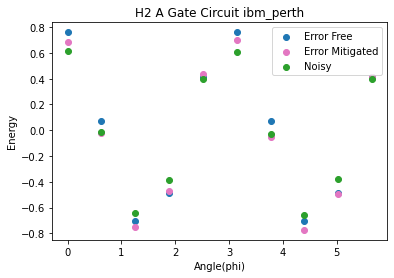

In [6]:
plt.scatter(angles, efs, c = 'tab:blue', label = 'Error Free')
plt.scatter(angles, ems, c = 'tab:pink', label = 'Error Mitigated')
plt.scatter(angles, ns, c = 'tab:green', label = 'Noisy')
plt.xlabel('Angle(phi)')
plt.ylabel('Energy')
plt.title('H2 A Gate Circuit ibm_perth')
plt.legend()

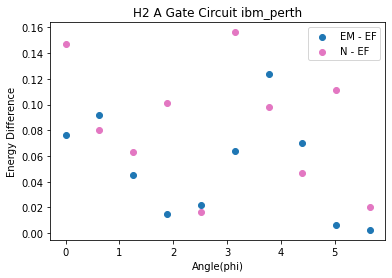

In [7]:
plt.scatter(angles, np.abs(np.array(ems) - np.array(efs)), c = 'tab:blue', label = 'EM - EF')
plt.scatter(angles, np.abs(np.array(ns) - np.array(efs)), c = 'tab:pink', label = 'N - EF')
plt.xlabel('Angle(phi)')
plt.ylabel('Energy Difference')
plt.title('H2 A Gate Circuit ibm_perth')
plt.legend()

In [8]:
ansatz.draw()

┌───┐┌───┐                                                          »
q_0: ┤ X ├┤ X ├─────────────────────────────────■────────────────────────»
     └───┘└─┬─┘┌────────────────────┐┌───────┐┌─┴─┐┌────────────────────┐»
q_1: ───────■──┤ Ry(theta[0] + π/2) ├┤ Rz(π) ├┤ X ├┤ Ry(theta[0] + π/2) ├»
               └────────────────────┘└───────┘└───┘└────────────────────┘»
«              ┌───┐
«q_0: ─────────┤ X ├
«     ┌───────┐└─┬─┘
«q_1: ┤ Rz(π) ├──■──
«     └───────┘

In [9]:
q

(array([ 1.00143303, -0.0839197 , -0.04596048,  0.72609366, -0.53852554,
         0.05230094,  0.03494002, -0.15298328,  0.11513422, -0.3891762 ,
        -0.21659121,  0.47773974,  0.04420127,  0.06780042,  0.191609  ,
        -0.06323818, -0.01372597]),
 ['II',
  'IX',
  'IY',
  'IZ',
  'XI',
  'XX',
  'XY',
  'XZ',
  'YI',
  'YX',
  'YY',
  'YZ',
  'ZI',
  'ZX',
  'ZY',
  'ZZ',
  'q0'])